In [364]:
!git clone https://github.com/vijayananthm/TrainingTracks.git

Cloning into 'TrainingTracks'...
remote: Enumerating objects: 12163, done.
remote: Counting objects: 100% (12163/12163), done.
remote: Compressing objects: 100% (12163/12163), done.
remote: Total 12163 (delta 0), reused 12163 (delta 0), pack-reused 0
Receiving objects: 100% (12163/12163), 156.98 MiB | 34.38 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [365]:
!ls TrainingTracks

driving_log.csv  IMG


In [366]:
!pip3 install imgaug

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpltimage
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import random
import os
import ntpath

In [368]:
datadir = 'TrainingTracks'
columns = ['center','left','right','steering','throttle','reverse','speed']
df = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names= columns)
pd.set_option('display.max_colwidth',-1)
df.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Vijay\Studies and Personal\ArtificalIntelligence\Self Driving Car\Training Data1\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [0]:
def get_tail(path):
  remain, tail = ntpath.split(path)
  return tail

df['center'] = df['center'].apply(get_tail)
df['left'] = df['left'].apply(get_tail)
df['right'] = df['right'].apply(get_tail)

In [336]:
df.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_11_29_12_41_33_809.jpg,left_2018_11_29_12_41_33_809.jpg,right_2018_11_29_12_41_33_809.jpg,0.0,0.0,0.0,0.000079
1,center_2018_11_29_12_41_33_941.jpg,left_2018_11_29_12_41_33_941.jpg,right_2018_11_29_12_41_33_941.jpg,0.0,0.0,0.0,0.000083
2,center_2018_11_29_12_41_34_041.jpg,left_2018_11_29_12_41_34_041.jpg,right_2018_11_29_12_41_34_041.jpg,0.0,0.0,0.0,0.000078
3,center_2018_11_29_12_41_34_143.jpg,left_2018_11_29_12_41_34_143.jpg,right_2018_11_29_12_41_34_143.jpg,0.0,0.0,0.0,0.000080
4,center_2018_11_29_12_41_34_249.jpg,left_2018_11_29_12_41_34_249.jpg,right_2018_11_29_12_41_34_249.jpg,0.0,0.0,0.0,0.000078


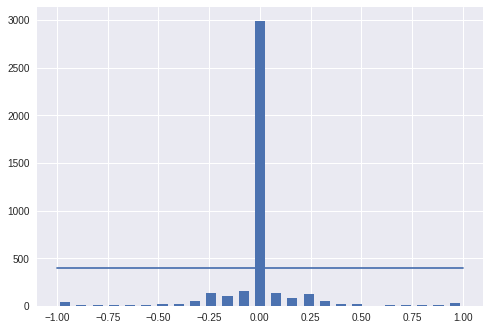

In [371]:
num_bins = 25
sample_threshold = 400
hist, bins = np.histogram(df['steering'], num_bins)
center = (bins[:-1] + bins[1:])/2
plt.bar(center,hist, width = 0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), (sample_threshold,sample_threshold))

In [0]:
remove_list = []
for j in range(num_bins):
  lst = []
  for i in range(len(df['steering'])):
    if df['steering'][i] >= bins[j] and df['steering'][i] <= bins[j+1]:
      lst.append(i)
  lst = shuffle(lst)
  lst = lst[sample_threshold:]
  remove_list.extend(lst)
df.drop(remove_list, inplace=True)

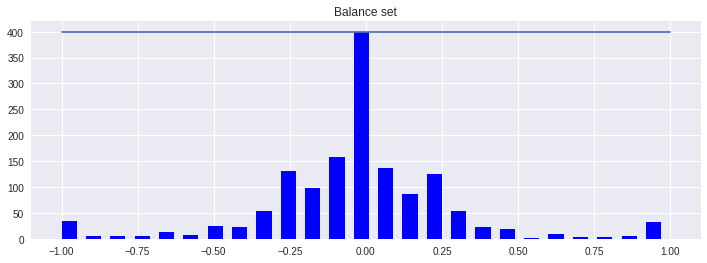

In [373]:
fig, axes = plt.subplots(1, 1, figsize = (12,4))
axes.hist(df['steering'], bins = num_bins, width = 0.05, color = 'blue')
axes.set_title('Balance set')
axes.plot((np.min(df['steering']), np.max(df['steering'])), (sample_threshold,sample_threshold))

In [0]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(df)):
    row_data = df.iloc[i]
    center, left, right, steer = row_data[0],row_data[1], row_data[2], row_data[3]
    image_path.append(os.path.join(datadir, center))
    steering.append(steer)
  image_paths = np.array(image_path)
  steerings = np.array(steering)
  return image_paths, steerings
                                                                    

In [0]:
image_paths, steerings = load_img_steering(datadir+'/IMG', df)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 20)

Text(0.5,1,'Validation set')

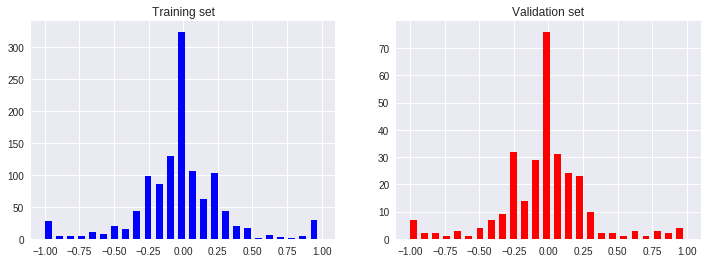

In [377]:
fig, axes = plt.subplots(1, 2, figsize = (12,4))
axes[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training set')
axes[1].hist(y_val, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title('Validation set')

In [0]:
def zooming(img):
  zoom = iaa.Affine(scale = (1,1.3))
  img = zoom.augment_image(img)
  return img

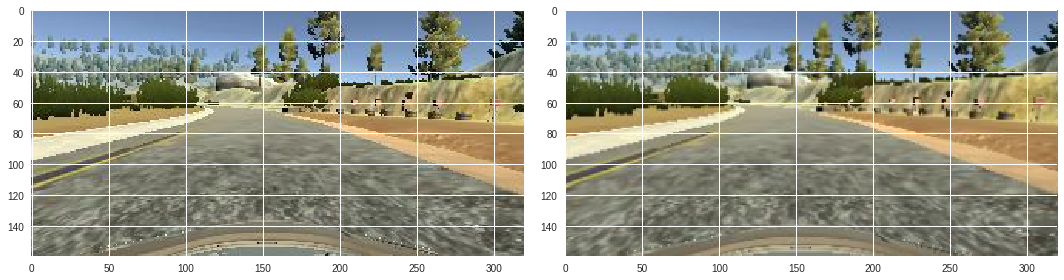

In [379]:
image = image_paths[random.randint(0, len(image_paths)-1)]
original_image = mpltimage.imread(image)
zoomed_image = zooming(original_image)
fig, axes = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[1].imshow(zoomed_image)

In [0]:
def pan(img):
  pan = iaa.Affine(translate_percent = {"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
  img = pan.augment_image(img)
  return img

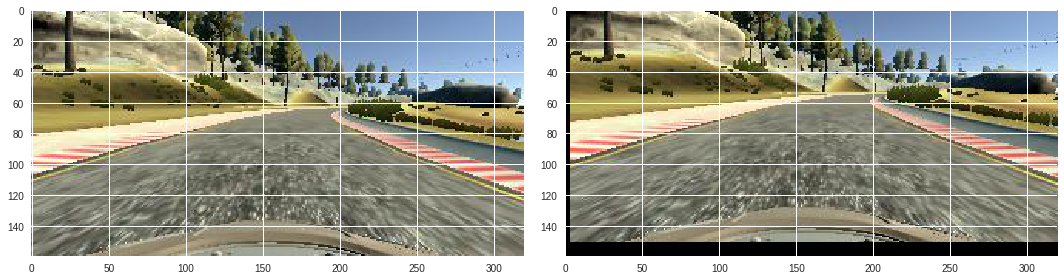

In [381]:
image = image_paths[random.randint(0, len(image_paths)-1)]
original_image = mpltimage.imread(image)
zoomed_image = pan(original_image)
fig, axes = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[1].imshow(zoomed_image)

In [0]:
def random_bright(img):
  brightness = iaa.Multiply((0.2,1.2))
  img = brightness.augment_image(img)
  return img

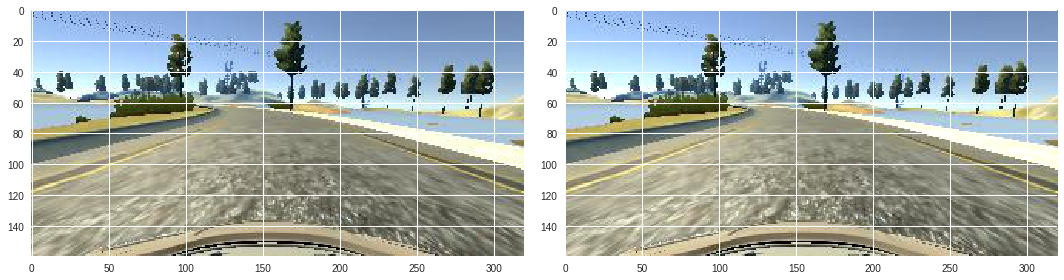

In [383]:
image = image_paths[random.randint(0, len(image_paths)-1)]
original_image = mpltimage.imread(image)
zoomed_image = random_bright(original_image)
fig, axes = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[1].imshow(zoomed_image)

In [0]:
def image_flip(img, steering_angle):
  img = cv2.flip(img, 1)
  steering_angle = -steering_angle
  return img, steering_angle

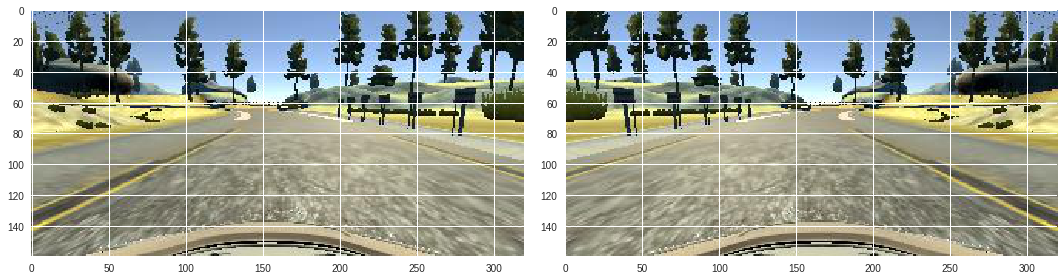

In [385]:
random_index = random.randint(0, len(image_paths)-1)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpltimage.imread(image)
zoomed_image, steering_angle = image_flip(original_image, steering_angle)
fig, axes = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[1].imshow(zoomed_image)

In [0]:
def random_augment(img_path, steering_angle):
  img = mpltimage.imread(img_path)
  if np.random.rand() < 0.5:
    img = pan(img)
  if np.random.rand() < 0.5:
    img = zooming(img)
  if np.random.rand() < 0.5:
    img, steering_angle = image_flip(img, steering_angle)
  if np.random.rand() < 0.5:
    img = random_bright(img)
  return img, steering_angle

In [0]:
def img_preprocess(img):
  img = img[60:130,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

In [0]:
def batch_generator(imges, steering_angles, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, (len(imges) -1))
      if istraining:
        img, steering = random_augment(imges[random_index], steering_angles[random_index])
      else:
        img = mpltimage.imread(imges[random_index])
        steering = steering_angles[random_index]
      img = img_preprocess(img)
      batch_img.append(img)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

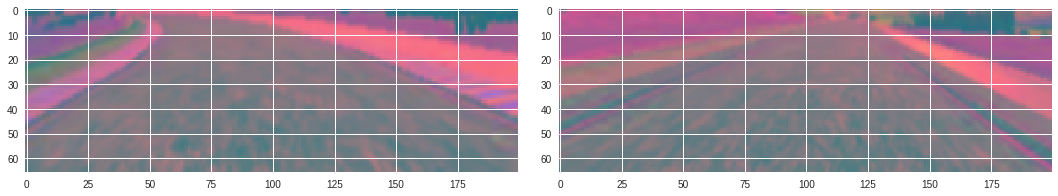

In [389]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, True))
x_val_gen, y_val_gen = next(batch_generator(X_val, y_val, 1, False))


fig, axes = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axes[0].imshow(x_train_gen[0])
axes[1].imshow(x_val_gen[0])

In [0]:
#X_train = np.array(list(map(img_preprocess,X_train)))
#X_val = np.array(list(map(img_preprocess,X_val)))

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, kernel_size= (5, 5) , input_shape = (66, 200, 3), activation='elu', strides = 2 ))
  model.add(Conv2D(36, kernel_size= (5, 5) , activation='elu', strides = 2 ))
  model.add(Conv2D(48, kernel_size= (5, 5) , activation='elu', strides = 2 ))
  model.add(Conv2D(64, kernel_size= (3, 3) , activation='elu'))
  model.add(Conv2D(64, kernel_size= (3, 3) , activation='elu'))
  #model.add(Dropout(0.5))
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(1))
  
  adam = Adam(lr=0.0001)
  model.compile(loss='mse', optimizer = adam, metrics = ['accuracy'])
  return model
                   

In [391]:
model = nvidia_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_11 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 100)               115300    
__________

In [392]:
h = model.fit_generator(batch_generator(X_train, y_train, 100, True), 
                        steps_per_epoch = 300, 
                        epochs = 10, 
                        validation_data = batch_generator(X_val, y_val, 100, False), 
                        validation_steps = 200,
                        shuffle = 1,
                        verbose = 1)

Epoch 1/10
300/300 [==============================] - 180s 601ms/step - loss: 0.0776 - acc: 0.2768 - val_loss: 0.0528 - val_acc: 0.2728
Epoch 2/10
300/300 [==============================] - 176s 586ms/step - loss: 0.0632 - acc: 0.2798 - val_loss: 0.0515 - val_acc: 0.2691
Epoch 3/10
300/300 [==============================] - 174s 580ms/step - loss: 0.0581 - acc: 0.2885 - val_loss: 0.0444 - val_acc: 0.2804
Epoch 4/10
300/300 [==============================] - 175s 583ms/step - loss: 0.0515 - acc: 0.2973 - val_loss: 0.0399 - val_acc: 0.2807
Epoch 5/10
300/300 [==============================] - 174s 581ms/step - loss: 0.0442 - acc: 0.3019 - val_loss: 0.0400 - val_acc: 0.2816
Epoch 6/10
300/300 [==============================] - 176s 585ms/step - loss: 0.0430 - acc: 0.3020 - val_loss: 0.0352 - val_acc: 0.2843
Epoch 7/10
300/300 [==============================] - 177s 589ms/step - loss: 0.0403 - acc: 0.3095 - val_loss: 0.0357 - val_acc: 0.2849
Epoch 8/10
300/300 [============================

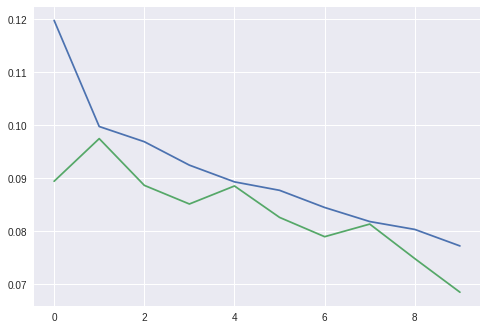

In [360]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

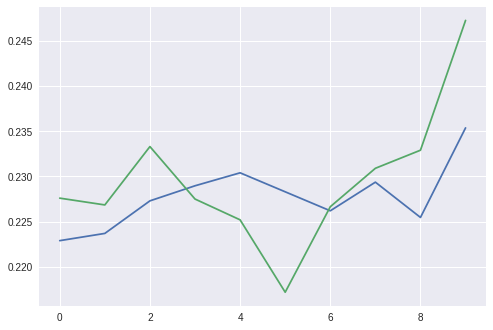

In [361]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')